<a href="https://colab.research.google.com/github/Rohan5076/Model-monitering-and-Explanable-AI/blob/main/Categorical_and_mixed_type_data_drift_detection_on_income_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Categorical and mixed type data drift detection on income prediction**

# Method
The drift detector applies feature-wise two-sample Kolmogorov-Smirnov (K-S) tests for the continuous numerical features and Chi-Squared tests for the categorical features. For multivariate data, the obtained p-values for each feature are aggregated either via the Bonferroni or the False Discovery Rate (FDR) correction. The Bonferroni correction is more conservative and controls for the probability of at least one false positive. The FDR correction on the other hand allows for an expected fraction of false positives to occur.

# **Dataset**
The instances contain a person’s characteristics like age, marital status or education while the label represents whether the person makes more or less than $50k per year. The dataset consists of a mixture of numerical and categorical features. It is fetched using the Alibi library, which can be installed with pip:

In [1]:
!pip install alibi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 472 kB 4.8 MB/s 
     |████████████████████████████████| 5.8 MB 31.3 MB/s 
     |████████████████████████████████| 98.5 MB 107 kB/s 
     |████████████████████████████████| 7.6 MB 45.8 MB/s 
     |████████████████████████████████| 182 kB 58.5 MB/s 


In [9]:
!pip install alibi_detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 4.7 MB/s 
     |████████████████████████████████| 3.4 MB 43.1 MB/s 
     |████████████████████████████████| 34.5 MB 1.4 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


In [10]:
import alibi
import matplotlib.pyplot as plt
import numpy as np

from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.saving import save_detector, load_detector

# Load income prediction dataset
The fetch_adult function returns a Bunch object containing the instances, the targets, the feature names and a dictionary with as keys the column indices of the categorical features and as values the possible categories for each categorical variable.

In [11]:
adult = alibi.datasets.fetch_adult()
X, y = adult.data, adult.target
feature_names = adult.feature_names
category_map = adult.category_map
X.shape, y.shape

((32561, 12), (32561,))

We split the data in a reference set and 2 test sets on which we test the data drift:

In [12]:
n_ref = 10000
n_test = 10000

X_ref, X_t0, X_t1 = X[:n_ref], X[n_ref:n_ref + n_test], X[n_ref + n_test:n_ref + 2 * n_test]
X_ref.shape, X_t0.shape, X_t1.shape

((10000, 12), (10000, 12), (10000, 12))

# Detect drift
We need to provide the drift detector with the columns which contain categorical features so it knows which features require the Chi-Squared and which ones require the K-S univariate test. We can either provide a dict with as keys the column indices and as values the number of possible categories or just set the values to None and let the detector infer the number of categories from the reference data as in the example below:

In [13]:
categories_per_feature = {f: None for f in list(category_map.keys())}

Initialize the detector:

In [14]:
cd = TabularDrift(X_ref, p_val=.05, categories_per_feature=categories_per_feature)

We can also save/load an initialised detector:

In [15]:
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

Now we can check whether the 2 test sets are drifting from the reference data:

In [16]:
preds = cd.predict(X_t0)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


Let’s take a closer look at each of the features. The preds dictionary also returns the K-S or Chi-Squared test statistics and p-value for each feature:

In [17]:
for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Age -- K-S 0.012 -- p-value 0.508
Workclass -- Chi2 8.487 -- p-value 0.387
Education -- Chi2 4.753 -- p-value 0.576
Marital Status -- Chi2 3.160 -- p-value 0.368
Occupation -- Chi2 8.194 -- p-value 0.415
Relationship -- Chi2 0.485 -- p-value 0.993
Race -- Chi2 0.587 -- p-value 0.965
Sex -- Chi2 0.217 -- p-value 0.641
Capital Gain -- K-S 0.002 -- p-value 1.000
Capital Loss -- K-S 0.002 -- p-value 1.000
Hours per week -- K-S 0.012 -- p-value 0.508
Country -- Chi2 9.991 -- p-value 0.441


None of the feature-level p-values are below the threshold:

In [18]:
preds['data']['threshold']

0.004166666666666667

If you are interested in individual feature-wise drift, this is also possible:

In [19]:
fpreds = cd.predict(X_t0, drift_type='feature')


In [20]:
for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    is_drift = fpreds['data']['is_drift'][f]
    stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Age -- Drift? No! -- K-S 0.012 -- p-value 0.508
Workclass -- Drift? No! -- Chi2 8.487 -- p-value 0.387
Education -- Drift? No! -- Chi2 4.753 -- p-value 0.576
Marital Status -- Drift? No! -- Chi2 3.160 -- p-value 0.368
Occupation -- Drift? No! -- Chi2 8.194 -- p-value 0.415
Relationship -- Drift? No! -- Chi2 0.485 -- p-value 0.993
Race -- Drift? No! -- Chi2 0.587 -- p-value 0.965
Sex -- Drift? No! -- Chi2 0.217 -- p-value 0.641
Capital Gain -- Drift? No! -- K-S 0.002 -- p-value 1.000
Capital Loss -- Drift? No! -- K-S 0.002 -- p-value 1.000
Hours per week -- Drift? No! -- K-S 0.012 -- p-value 0.508
Country -- Drift? No! -- Chi2 9.991 -- p-value 0.441


What about the second test set?

In [21]:
preds = cd.predict(X_t1)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


We can again investigate the individual features:

In [22]:
for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = feature_names[f]
    is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Age -- Drift? No! -- K-S 0.007 -- p-value 0.966
Workclass -- Drift? No! -- Chi2 5.800 -- p-value 0.670
Education -- Drift? No! -- Chi2 5.413 -- p-value 0.492
Marital Status -- Drift? No! -- Chi2 1.167 -- p-value 0.761
Occupation -- Drift? No! -- Chi2 12.296 -- p-value 0.138
Relationship -- Drift? No! -- Chi2 6.520 -- p-value 0.259
Race -- Drift? No! -- Chi2 1.417 -- p-value 0.841
Sex -- Drift? No! -- Chi2 0.008 -- p-value 0.928
Capital Gain -- Drift? No! -- K-S 0.005 -- p-value 0.998
Capital Loss -- Drift? No! -- K-S 0.003 -- p-value 1.000
Hours per week -- Drift? No! -- K-S 0.004 -- p-value 1.000
Country -- Drift? No! -- Chi2 11.256 -- p-value 0.338


It seems like there is little divergence in the distributions of the features between the reference and test set. Let’s visualize this:

In [23]:
def plot_categories(idx: int) -> None:
    # reference data
    x_ref_count = {f: [(X_ref[:, f] == v).sum() for v in vals]
                   for f, vals in cd.x_ref_categories.items()}
    fref_drift = {cat: x_ref_count[idx][i] for i, cat in enumerate(category_map[idx])}

    # test set
    cats = {f: list(np.unique(X_t1[:, f])) for f in categories_per_feature.keys()}
    X_count = {f: [(X_t1[:, f] == v).sum() for v in vals] for f, vals in cats.items()}
    fxt1_drift = {cat: X_count[idx][i] for i, cat in enumerate(category_map[idx])}

    # plot bar chart
    plot_labels = list(fxt1_drift.keys())
    ind = np.arange(len(plot_labels))
    width = .35
    fig, ax = plt.subplots()
    p1 = ax.bar(ind, list(fref_drift.values()), width)
    p2 = ax.bar(ind + width, list(fxt1_drift.values()), width)
    ax.set_title(f'Counts per category for {feature_names[idx]} feature')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(plot_labels)
    ax.legend((p1[0], p2[0]), ('Reference', 'Test'), loc='upper right', ncol=2)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Categories')
    plt.xticks(list(np.arange(len(plot_labels))), plot_labels, rotation='vertical')
    plt.show()

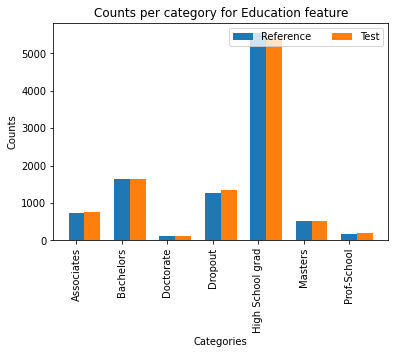

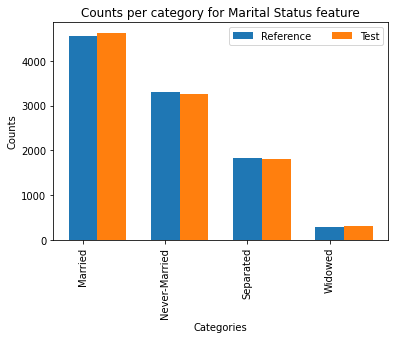

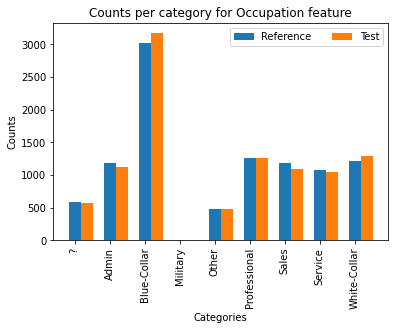

In [24]:
plot_categories(2)
plot_categories(3)
plot_categories(4)

# **Categorical data drift**
While the TabularDrift detector works fine with numerical or categorical features only, we can also directly use a categorical drift detector. In this case, we don’t need to specify the categorical feature columns. First we construct a categorical-only dataset and then use the ChiSquareDrift detector:

In [25]:

cols = list(category_map.keys())
cat_names = [feature_names[_] for _ in list(category_map.keys())]
X_ref_cat, X_t0_cat = X_ref[:, cols], X_t0[:, cols]
X_ref_cat.shape, X_t0_cat.shape

((10000, 8), (10000, 8))

In [26]:
cd = ChiSquareDrift(X_ref_cat, p_val=.05)
preds = cd.predict(X_t0_cat)
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


In [27]:
print(f"Threshold {preds['data']['threshold']}")
for f in range(cd.n_features):
    fname = cat_names[f]
    is_drift = (preds['data']['p_val'][f] < preds['data']['threshold']).astype(int)
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

Threshold 0.00625
Workclass -- Drift? No! -- Chi2 8.487 -- p-value 0.387
Education -- Drift? No! -- Chi2 4.753 -- p-value 0.576
Marital Status -- Drift? No! -- Chi2 3.160 -- p-value 0.368
Occupation -- Drift? No! -- Chi2 8.194 -- p-value 0.415
Relationship -- Drift? No! -- Chi2 0.485 -- p-value 0.993
Race -- Drift? No! -- Chi2 0.587 -- p-value 0.965
Sex -- Drift? No! -- Chi2 0.217 -- p-value 0.641
Country -- Drift? No! -- Chi2 9.991 -- p-value 0.441
